<a href="https://colab.research.google.com/github/sampurnapradhan/Integrated-System-for-News-Classification-and-Fallacy-Detection-in-News-Articles/blob/main/Fallacy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from bs4 import BeautifulSoup
import json




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the JSON dataset
dataset = '/content/drive/MyDrive/dessertation/datacollection/train.json'
# Load the dataset
with open(dataset, "r") as f:
    data = json.load(f)

# Flatten the dataset
rows = []
for article in data:
    article_title = article["title"]
    article_content = BeautifulSoup(article["content"], "html.parser").get_text()
    for comment in article["comments"]:
        rows.append({
            "article_id": article["id"],
            "article_title": article_title,
            "article_content": article_content,
            "comment_id": comment["id"],
            "comment_text": comment["comment"],
            "fallacy_type": comment["fallacy"]
        })

# Create a DataFrame
f_df = pd.DataFrame(rows)

In [ ]:
f_df

,article_id,article_title,article_content,comment_id,comment_text,fallacy_type
0,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,5584,Lack of transparency in government isn't unexp...,none
1,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,5582,While the issues discussed here should be addr...,appeal to authority
2,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,5583,The excuse that Brazilian municipalities do no...,none
3,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,6183,This is what's to be expected of developing an...,none
4,262,"Even with a law, São Paulo's municipalities ar...",\nThis story was written by Paulo Talarico and...,6182,"Sad to say, I have to agree with you. Rulers c...",appeal to tradition
...,...,...,...,...,...,...
5365,644,"For Asian activists, boycotting Disney's ‘Mula...",\nActivists from a number of Asian countries a...,9129,A boycott can be a powerful weapon. Let's hope...,none
5366,644,"For Asian activists, boycotting Disney's ‘Mula...",\nActivists from a number of Asian countries a...,9128,This is something we should all participate in...,appeal to authority
5367,644,"For Asian activists, boycotting Disney's ‘Mula...",\nActivists from a number of Asian countries a...,11228,"The movie is part of the problem, though. Di...",none
5368,644,"For Asian activists, boycotting Disney's ‘Mula...",\nActivists from a number of Asian countries a...,11229,"The propaganda does happen in every country, a...",slippery slope


In [ ]:

f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5370 entries, 0 to 5369
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       5370 non-null   int64 
 1   article_title    5370 non-null   object
 2   article_content  5370 non-null   object
 3   comment_id       5370 non-null   object
 4   comment_text     5370 non-null   object
 5   fallacy_type     5370 non-null   object
dtypes: int64(1), object(5)
memory usage: 251.8+ KB


In [ ]:
f_df.isnull().sum()

,0
article_id,0
article_title,0
article_content,0
comment_id,0
comment_text,0
fallacy_type,0


In [ ]:
# Create binary classification column
f_df["fallacy_present"] = f_df["fallacy_type"].apply(lambda x: 0 if x == "none" else 1)


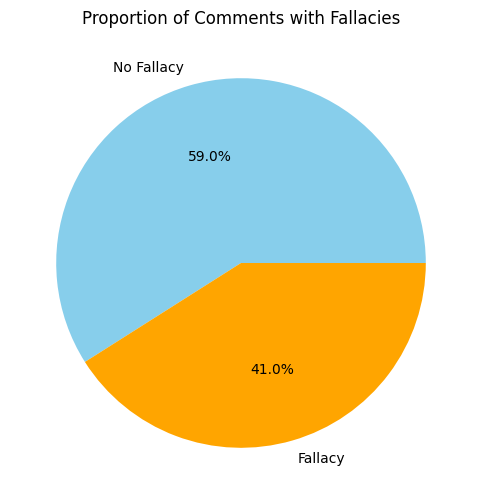

In [ ]:
# Count presence vs. absence of fallacies
fallacy_presence_counts = f_df['fallacy_present'].value_counts()

# Plot fallacy presence distribution
plt.figure(figsize=(8, 6))
fallacy_presence_counts.plot(kind='pie', labels=['No Fallacy', 'Fallacy'], autopct='%1.1f%%', colors=['skyblue', 'orange'])
plt.title('Proportion of Comments with Fallacies')
plt.ylabel('')
plt.show()


In [ ]:
# Use only comment text for classification
f_df["input_text"] = f_df["comment_text"]

In [ ]:
# Stratified train, val, and test split
train_df, temp_df = train_test_split(f_df, test_size=0.3, random_state=42, stratify=f_df["fallacy_present"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["fallacy_present"])

In [ ]:

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train = train_df["input_text"]
y_train = train_df["fallacy_present"]


In [ ]:

# Tokenize text for SMOTE
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
X_train_tokenized = tokenizer(list(X_train), padding=True, truncation=True, max_length=512, return_tensors="np")["input_ids"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:


# Apply SMOTE
X_smote, y_smote = smote.fit_resample(X_train_tokenized, y_train)

In [ ]:

# Convert back to text
balanced_train_df = pd.DataFrame({
    "input_text": tokenizer.batch_decode(X_smote, skip_special_tokens=True),
    "fallacy_present": y_smote
})

In [ ]:
# Dataset class
class FallacyDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        inputs = self.tokenizer(
            row["input_text"],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(row["fallacy_present"], dtype=torch.long),
        }


In [ ]:
# Create datasets and dataloaders
train_dataset = FallacyDataset(balanced_train_df, tokenizer, max_len=512)
val_dataset = FallacyDataset(val_df, tokenizer, max_len=512)
test_dataset = FallacyDataset(test_df, tokenizer, max_len=512)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss()(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss

In [ ]:
# Load BERT model for binary classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = len(train_loader) * 6  # Assuming 6 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:

# Initialize Focal Loss  with specific values for α
# α (balancing factor) and
# γ
# γ (focusing parameter).
loss_fn = FocalLoss(alpha=0.25, gamma=2)


In [ ]:

# Training loop
epochs = 6
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['labels'].to(device)
        }
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, inputs["labels"])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()

    print(f"Training Loss: {total_loss / len(train_loader)}")

Epoch 1/6
Training Loss: 0.025675849678196215
Epoch 2/6
Training Loss: 0.012397153199734775
Epoch 3/6
Training Loss: 0.005137914248197768
Epoch 4/6
Training Loss: 0.0022640868867444815
Epoch 5/6
Training Loss: 0.0010400942899601382
Epoch 6/6
Training Loss: 0.0005398970097253717


In [ ]:

    # Validation loop
    model.eval()
    val_predictions, val_labels = [], []
    for batch in val_loader:
        with torch.no_grad():
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)
            val_predictions.extend(preds.cpu().numpy())
            val_labels.extend(batch["labels"].cpu().numpy())
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average=None)
    print(f"Class 0 (No Fallacy) - Precision: {precision[0]}, Recall: {recall[0]}, F1-Score: {f1[0]}")
    print(f"Class 1 (Fallacy) - Precision: {precision[1]}, Recall: {recall[1]}, F1-Score: {f1[1]}")

Class 0 (No Fallacy) - Precision: 0.7638888888888888, Recall: 0.6666666666666666, F1-Score: 0.7119741100323624
Class 1 (Fallacy) - Precision: 0.7872340425531915, Recall: 0.8568421052631578, F1-Score: 0.8205645161290323


In [ ]:

# Test the model
model.eval()
test_predictions, test_labels = [], []
for batch in test_loader:
    with torch.no_grad():
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        test_predictions.extend(preds.cpu().numpy())
        test_labels.extend(batch["labels"].cpu().numpy())

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Classification report
print("Test Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=["No Fallacy", "Fallacy"]))



Test Classification Report:
              precision    recall  f1-score   support

  No Fallacy       0.76      0.66      0.71       331
     Fallacy       0.79      0.85      0.82       475

    accuracy                           0.78       806
   macro avg       0.77      0.76      0.76       806
weighted avg       0.78      0.78      0.77       806



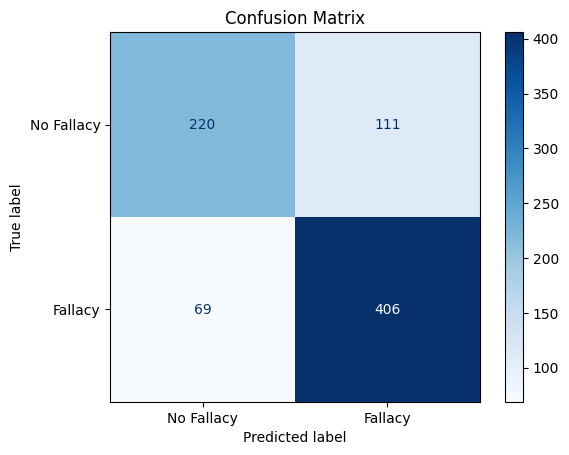

In [ ]:
#confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fallacy", "Fallacy"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save the fine-tuned model
model.save_pretrained("/content/drive/MyDrive/dessertation/fallacy_model")
tokenizer.save_pretrained("/content/drive/MyDrive/dessertation/fallacy_model")

('/content/drive/MyDrive/dessertation/fallacy_model/tokenizer_config.json',
 '/content/drive/MyDrive/dessertation/fallacy_model/special_tokens_map.json',
 '/content/drive/MyDrive/dessertation/fallacy_model/vocab.txt',
 '/content/drive/MyDrive/dessertation/fallacy_model/added_tokens.json')